# Using ERA5 hourly data in daily hydrological modelling

Here we use birdy's WPS client to launch the HMETS hydrological model on the server and analyze the output. We prepare ERA5 data after fetching it on the THREDDS server and tailoring it to our needs.

In [8]:
from birdy import WPSClient
import regionmask # conda install -c conda-forge regionmask
import salem # pip install salem

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import netCDF4 as nc

# Set environment variable RAVEN_WPS_URL to "http://localhost:9099" to run on the default local server
#url = os.environ.get("RAVEN_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")

# THIS CHANGED TO REFLECT MASTER, NOT LATEST RELEASE!
url="http://localhost:9099" 

wps = WPSClient(url)

# My shapefile
vec='/home/ets/src/raven/raven/tests/testdata/watershed_vector/LSJ_LL/LSJ_LL.shp'

In [9]:
# SETUP THE RUN PARAMETERS, for now only the start and end years of the simulation, the rest is hard-coded to 
# the Salmon-river example

startYear=2007 # Year of the beginning of the simulation
endYear=2008 # Year of the end of the simulation


In [10]:
# Define the ERA5 data URLs for the OPeNDAP netCDF files
tas_urlBase = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ecmwf/era5/tas_era5_reanalysis_hourly_"
precip_urlBase = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ecmwf/era5/pr_era5_reanalysis_hourly_"


In [11]:
# Get information on the Salmon catchment from our test database. This will need to be changed to allow other data
salmon=xr.open_dataset(TESTDATA['raven-hmets-nc-ts'])
salmon_lat = salmon.lat.values[0]
salmon_lon = salmon.lon.values[0]

In [12]:
# Write file path for input data
dirpath=os.getcwd()
filepath = dirpath + "/ts.nc"


In [13]:
"""Return a netCDF file with hourly ERA5 data at the Salmon location."""
# Get first year of data. 
## NOTE THAT HERE, THE ONLY METHOD IS THE NEAREST POINT, WHEREAS WE WILL NEED TO HAVE A MORE USEFUL METHOD SUCH AS AVERAGE OF CATCHMENT POLYGON

firstYear=str(startYear)
tasYear=xr.open_dataset(tas_urlBase + firstYear + '.nc')
prYear=xr.open_dataset(precip_urlBase + firstYear + '.nc')


In [15]:
shdf=salem.read_shapefile(vec)
shdf

,SUPERFICIE,NOM,ARRONDIE,geometry,min_x,max_x,min_y,max_y
0,2489.88211,Rivière aux Rats,2490.0,"MULTIPOLYGON (((-72.71999 48.49016, -72.72055 ...",-74.428788,-71.356948,47.392604,51.151291


In [16]:
tasSub=tasYear.salem.roi(shape=shdf)

MemoryError: Unable to allocate 16.9 GiB for an array with shape (8760, 721, 1440) and data type int16

In [7]:
# Now extract all following years. It might take a few minutes depending on the number of years
# that are fetched through the server. 
## ALSO THE SAME LIMITATION RELATED TO THE NEAREST POINT vs AVERAGE OF POINTS WITHIN CONTOUR (or Thiessen, inverse distance weighting, etc.)
for i in range(startYear+1,endYear+1):
        
    tasYear=xr.concat([tasYear,xr.open_dataset(tas_urlBase + str(i) + '.nc').sel(longitude=salmon_lon+360, latitude=salmon_lat, method='nearest')],dim='time')
    prYear=xr.concat([prYear,xr.open_dataset(precip_urlBase + str(i) + '.nc').sel(longitude=salmon_lon+360, latitude=salmon_lat, method='nearest')],dim='time')
    

In [8]:
# Now we need to merge pr and tas variables into one NetCDF file, and write to disk for future use.
main=tasYear.merge(prYear,compat='override')
main.to_netcdf(filepath)


In [9]:
# Finally, adjust the time units

# IT SEEMS THIS IS NEEDED IN PYTEST TESTS BUT NOT HERE?! IF I UNCOMMENT THIS, YEARS ARE 1900-01-01 to 1902-12-31...

#D = nc.Dataset(filepath, "a")
#D.variables["time"].units = "hours since 1900-01-01 00:00:00"
#D.close()

In [10]:
import json
# The model parameters. Can either be a string of comma separated values, a list, an array or a named tuple. 
params = '9.5019, 0.2774, 6.3942, 0.6884, 1.2875, 5.4134, 2.3641, 0.0973, 0.0464, 0.1998, 0.0222, -1.0919, ' \
            '     2.6851, 0.3740, 1.0000, 0.4739, 0.0114, 0.0243, 0.0069, 310.7211, 916.1947'

# Forcing files: Let's use the file we just created
ts=filepath

# Model configuration parameters
config = dict(
    start_date=dt.datetime(2007, 5, 1),
    end_date=dt.datetime(2007, 6, 30),
    area=4250.6,
    elevation=843.0,
    latitude=salmon_lat,
    longitude=salmon_lon,
    run_name='test_hmets_ERA5',
    rain_snow_fraction='RAINSNOW_DINGMAN', # <----- ##### THIS FAILS! NEED HELP HERE! ######
    nc_spec=json.dumps({'tas': {'linear_transform': (1.0, -273.15), 'time_shift': -.25},'pr': {'linear_transform': (.001, 0.0), 'time_shift': -.25}})  
)

# Let's call the model with the timeseries, model parameters and other configuration parameters
resp = wps.raven_hmets(ts=str(ts), params=params, **config)


In [11]:

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 

In [12]:
print(diagnostics)

:TimeStamp 2007-06-30 00:00:00.00
:HRUStateVariableTable
  :Attributes,SURFACE_WATER,ATMOSPHERE,ATMOS_PRECIP,PONDED_WATER,SOIL[0],SOIL[1],SNOW,SNOW_LIQ,CUM_SNOWMELT,CONVOLUTION[0],CONVOLUTION[1],AET,CONV_STOR[0],CONV_STOR[1],CONV_STOR[2],CONV_STOR[3],CONV_STOR[4],CONV_STOR[5],CONV_STOR[6],CONV_STOR[7],CONV_STOR[8],CONV_STOR[9],CONV_STOR[10],CONV_STOR[11],CONV_STOR[12],CONV_STOR[13],CONV_STOR[14],CONV_STOR[15],CONV_STOR[16],CONV_STOR[17],CONV_STOR[18],CONV_STOR[19],CONV_STOR[20],CONV_STOR[21],CONV_STOR[22],CONV_STOR[23],CONV_STOR[24],CONV_STOR[25],CONV_STOR[26],CONV_STOR[27],CONV_STOR[28],CONV_STOR[29],CONV_STOR[30],CONV_STOR[31],CONV_STOR[32],CONV_STOR[33],CONV_STOR[34],CONV_STOR[35],CONV_STOR[36],CONV_STOR[37],CONV_STOR[38],CONV_STOR[39],CONV_STOR[40],CONV_STOR[41],CONV_STOR[42],CONV_STOR[43],CONV_STOR[44],CONV_STOR[45],CONV_STOR[46],CONV_STOR[47],CONV_STOR[48],CONV_STOR[49],CONV_STOR[50],CONV_STOR[51],CONV_STOR[52],CONV_STOR[53],CONV_STOR[54],CONV_STOR[55],CONV_STOR[56],CONV_STOR[57]

The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [13]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 61, nbasins: 1)>
array([[  0.      ],
       [170.910938],
       [338.275726],
       [331.291534],
       [324.520171],
       [317.954487],
       [311.587377],
       [305.411813],
       [299.421441],
       [293.610265],
       [287.971893],
       [282.500234],
       [277.189594],
       [272.03469 ],
       [267.030179],
       [262.170738],
       [257.451235],
       [252.866979],
       [248.414179],
       [244.088482],
       [239.885117],
       [235.800063],
       [231.829217],
       [227.968514],
       [224.214367],
       [220.563234],
       [217.011309],
       [213.555534],
       [210.193251],
       [206.921116],
       [203.735709],
       [200.634106],
       [197.613846],
       [194.672218],
       [191.806306],
       [189.013504],
       [186.291866],
       [183.639959],
       [181.055268],
       [178.535195],
       [176.077661],
       [173.680467],
       [171.341763],
       [169.05983 ],
       [166.83262 ],
     

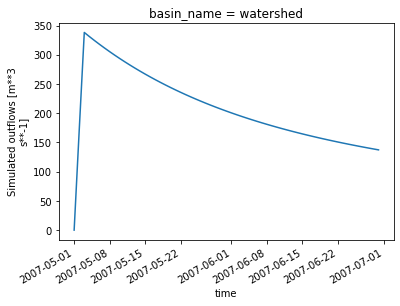

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

hydrograph.q_sim.plot()

In [15]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby(hydrograph.time.dt.month).mean(dim='time'))

Max:  <xarray.DataArray 'q_sim' ()>
array(338.27572589)
Mean:  <xarray.DataArray 'q_sim' ()>
array(208.87657765)
Monthly means:  <xarray.DataArray 'q_sim' (month: 2, nbasins: 1)>
array([[250.85094791],
       [165.50306171]])
Coordinates:
    basin_name  (nbasins) object ...
  * month       (month) int64 5 6
Dimensions without coordinates: nbasins
